# 네이버 영화리뷰 감성분석
## 코드

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다.
(146182, 41) (49157, 41)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   58  821 1695 6141    5  942   65   37]
106182
Epoch 1/3
208/208 [==============================] - 1s 4ms/step - loss: 0.6217 - accuracy: 0.7207 - val_loss: 0.4764 - val_accuracy: 0.8123
Epoch 2/3
208/208 [==============================] - 1s 4ms/step - loss: 0.3999 - accuracy: 0.8332 - val_loss: 0.3727 - val_accuracy: 0.8350
Epoch 3/3
208/208 [==============================] - 1s 3ms/step - loss: 0.3368 - accuracy: 0.8578 - val_loss: 0.3575 - val_accuracy: 0.8421
1537/1537 - 1s - loss: 0.3643 - accuracy: 0.8395
result :[0.3642738163471222, 0.8394531607627869]


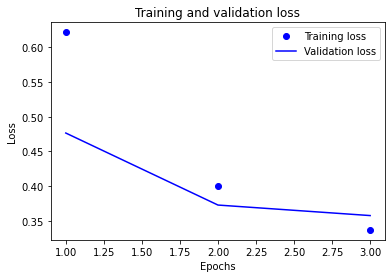

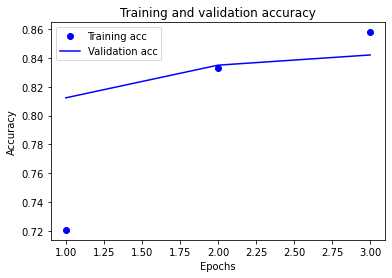

유의미 단어 찾기 :  [('차태현', 0.8837523460388184), ('앓', 0.8829506635665894), ('생존', 0.8802288770675659), ('유아인', 0.8648689985275269), ('짐', 0.8545851707458496), ('~~!!!', 0.8492945432662964), ('죠', 0.8485867977142334), ('깨알', 0.8435053825378418), ('9', 0.842865526676178), ('그리움', 0.8378609418869019)]


/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:229: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:235: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
/home/ssac14/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:236: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


유의미 단어 찾기 :  [('감명', 0.7177015542984009), ('감격', 0.6908232569694519), ('실망', 0.6267645359039307), ('감화', 0.6191877126693726), ('감탄', 0.6140127778053284), ('칭찬', 0.6059398055076599), ('존경', 0.6032299995422363), ('자극', 0.594598650932312), ('감복', 0.5902734994888306), ('호응', 0.5850393772125244)]
Epoch 1/3
208/208 [==============================] - 8s 38ms/step - loss: 0.4546 - accuracy: 0.7806 - val_loss: 0.3858 - val_accuracy: 0.8253
Epoch 2/3
208/208 [==============================] - 8s 39ms/step - loss: 0.3256 - accuracy: 0.8596 - val_loss: 0.3313 - val_accuracy: 0.8576
Epoch 3/3
208/208 [==============================] - 8s 38ms/step - loss: 0.2775 - accuracy: 0.8834 - val_loss: 0.3168 - val_accuracy: 0.8661
1537/1537 - 3s - loss: 0.3250 - accuracy: 0.8611
[0.32497599720954895, 0.8611184358596802]


In [4]:
import os
import warnings
from collections import Counter

import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
from konlpy.tag import Okt, Mecab
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from tensorflow.keras.initializers import Constant
from gensim.models.keyedvectors import Word2VecKeyedVectors


os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


# 1. 데이터 준비
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')
train_data.head()  # 맨위 5개 출력하기

# 2. 데이터 로더 구성
tokenizer = Mecab()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']


def load_data(train_data, test_data, num_words=10000):
    # train data
    train_data.drop_duplicates('document', inplace=True)  # 중복 제거
    train_data = train_data.dropna()  # 결측치 제거 - axis=0 NaN인 행을 제거
    X_train = []
    for sentence in train_data['document']:
        tmp = tokenizer.morphs(sentence)  # 토큰화
        tmp = [word for word in tmp if word not in stopwords]  # 불용어 제거
        X_train.append(tmp)

    # test data
    test_data.drop_duplicates('document', inplace=True)  # 중복 제거
    test_data = test_data.dropna()  # 결측치 제거 - axis=0 NaN인 행을 제거
    X_test = []
    for sentence in test_data['document']:
        tmp = tokenizer.morphs(sentence)  # 토큰화
        tmp = [word for word in tmp if word not in stopwords]  # 불용어 제거
        X_test.append(tmp)

    # word_to_index 구성
    words = list(np.concatenate(X_train))
    counter = Counter(words)  # length - 53,961
    counter = counter.most_common(num_words - 4)  # 가장 자주 사용되는 단어 순으로 정렬되어 형변환
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]  # length - 10,000
    word_to_index = {word: index for index, word in enumerate(vocab)}  # 형태 - {'the': 4}

    # 텍스트로 이루어진 리스트를 인덱스리스트로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))

    return X_train, y_train, X_test, y_test, word_to_index


X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index: word for word, index in word_to_index.items()}


# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다.
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word
                                       in sentence.split()]


# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다.
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]


# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다.
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in
                    encoded_sentence[1:])  # [1:]를 통해 <BOS>를 제외


# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다.
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


# 3. 모델구성을 위한 데이터 분석 및 가공
# 3-1. maxlen(문장 최대 길이) 값 찾아내기
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]  # 각각의 문장 길이를 담은 배열 생성
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))    # 15.969376315021577
print('문장길이 최대 : ', np.max(num_tokens))     # 116
print('문장길이 표준편차 : ', np.std(num_tokens))  # 12.843535456326455

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)  # 41
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)*100}%가 maxlen 설정값 이내에 포함됩니다.')

# 3-2. padding 설정
x_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
print(x_train.shape, x_test.shape)  # (146182, 41) (49157, 41)

# 3-3. train set & valid set 분리
x_val = x_train[:40000]
y_val = y_train[:40000]
x_train = x_train[40000:]
y_train = y_train[40000:]

print(x_train[0])
print(len(x_train))

# 4. 모델구성 및 훈련
# 어휘 사전 크기 & 워드벡터차원 수 설정
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)


# LSTM - loss: 0.3679 - accuracy: 0.8414
def model_1():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.LSTM(8))   # LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))  # 긍정/부정
    # 모델 훈련
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=5, batch_size=512, validation_data=(x_val, y_val), verbose=1)
    return model, history


# 4-2. Conv1D loss: 0.3563 - accuracy: 0.8471
def model_2():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.MaxPooling1D(5))
    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # 모델 훈련
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=3, batch_size=512, validation_data=(x_val, y_val), verbose=1)
    return model, history


# 4-3. GlobalMaxPooling1D loss: 0.3631 - accuracy: 0.8403
def model_3():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # 모델 훈련
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=3, batch_size=512, validation_data=(x_val, y_val), verbose=1)
    return model, history


model, history = model_3()

# 5. 모델 테스트
results = model.evaluate(x_test,  y_test, verbose=2)
print(f'result :{results}')


# 6. Loss, Accuracy 그래프 시각화 - 시간되면 한번에 나타내기로 수정하기
def check_training_n_validation_loss(history):
    history_dict = history.history
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')  # 파란색 점
    plt.plot(epochs, val_loss, 'b', label='Validation loss')  # 파란 실선
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()   # 그림 초기화

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


check_training_n_validation_loss(history)


# 7. 학습된 Embedding 레이어 분석 - gensim
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/koword2vec.txt'
f = open(word2vec_file_path, 'w')
f.write(f'{vocab_size-4} {word_vector_dim}\n')  # (9996, 16)

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
print('유의미 단어 찾기 : ', word_vectors.similar_by_word("감동"))

# 8. 한국어 Word2Vec 임베딩 활용하여 성능개선
# 한국어 Word2Vec은 다음 경로에서 구할 수 있습니다. https://github.com/Kyubyong/wordvectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'
word2vec = Word2Vec.load(word2vec_path)
print('유의미 단어 찾기 : ', word2vec.similar_by_word("감동"))

vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
for i in range(4, vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]


def model_embedding():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size,
                                     word_vector_dim,
                                     embeddings_initializer=Constant(embedding_matrix),
                                     input_length=maxlen,
                                     trainable=True))
    model.add(keras.layers.LSTM(256))
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # 모델 훈련
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=3, batch_size=512, validation_data=(x_val, y_val), verbose=1)
    return model, history


model, history = model_embedding()
results = model.evaluate(x_test,  y_test, verbose=2)
print(results)

def sentiment_predict(new_sentence):
    new_sentence = tokenizer.morphs(new_sentence)  # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords]  # 불용어 제거
    encoded = [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in new_sentence]  # 정수인코딩
    pad_new = keras.preprocessing.sequence.pad_sequences([encoded], value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)  # 패딩
    score = float(model.predict(pad_new))  # 예측
    print('score : ', score)
    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))
    return None


sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')
sentiment_predict('이 영화 핵노잼 ㅠㅠ')
sentiment_predict('이딴게 영화냐 ㅉㅉ')
sentiment_predict('감독 뭐하는 놈이냐?')
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

## 회고
### 이번 프로젝트에서 **어려웠던 점,**
워드임베딩을 적용한 모델과 적용하지 않은 모델간의 정확도 차이가 크게 나지 않았다. 노드에서는 잘 활용하면 5% 이상 성능이 향상된다고 하였는데, 크게 차이가 나지 않아 어떤 부분을 수정해줘야하는지 잘 이해가 가지 않았다.

### 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
위와 같은 이유로 아직 어떻게 수정해야할지 모르겠다. 또한, 마지막에 문장을 테스트해보았을 때 정확도가 약 86%정도임에도 불구하고 제대로 분류해내지 못했다. 사전의 단어수가 모자라서 그런 것인지, 모델을 좀더 개선해야하는 것인지 아직 의문이다.

### 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
세가지 모델을 각각 epoch를 가감하면서 비교해보았고, LSTM의 차원수를 증가시보았더니 지표(85%)를 넘었다.


### 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.


### **자기 다짐**
시간이 부족하여 이전에 했던 프로젝트보다 시간을 투자하지 못했다. 주말에 다시 한번 수정해보아야겠다. 